In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub


from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow import keras

from sklearn.model_selection import train_test_split

In [18]:
# Load training and testing dataframes
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [19]:
# Create training and testing arrays
training = np.array(df_train, dtype = 'float32')
testing = np.array(df_test, dtype='float32')

<AxesSubplot:xlabel='label', ylabel='count'>

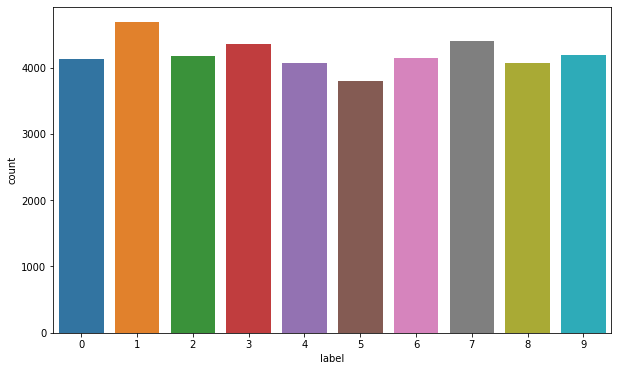

In [20]:
# check if the target classes are balanced
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=df_train)

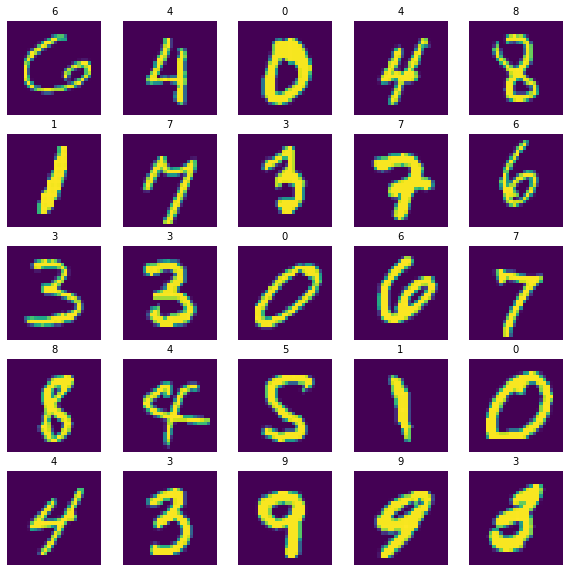

In [21]:
# Visualize the training data
W = 5
H = 5
fig, axes = plt.subplots(W, H, figsize = (10,10))
axes = axes.reshape(-1) # flaten the matrix into array

# Show a random number from testing images 
for i in np.arange(0, W * H): 
    # Select a random number
    index = np.random.randint(0, len(df_train))
    
    # Read and display an image with the selected index    
    axes[i].imshow(training[index,1:].reshape((28,28)))
    axes[i].set_title(training[index,0].astype(int), fontsize = 10) # the label
    axes[i].axis('off')

plt.show()

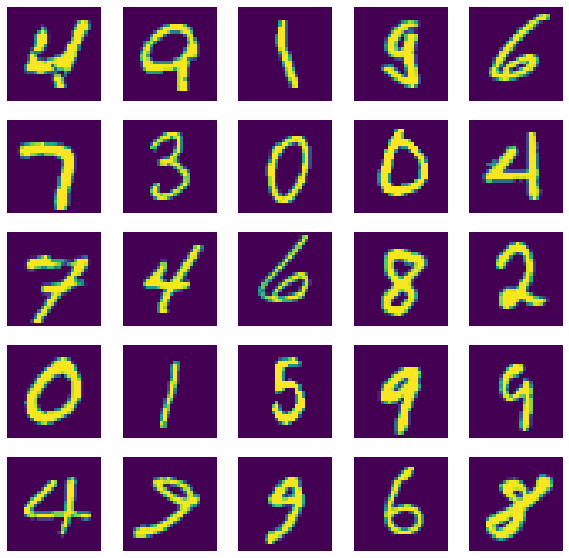

In [22]:
# visualize the test data
W = 5
H = 5
fig, axes = plt.subplots(W, H, figsize = (10,10))
axes = axes.reshape(-1) # flaten the matrix into array

# Show a random number from testing images 
for i in np.arange(0, W * H): 
    # Select a random number
    index = np.random.randint(0, len(testing))
    
    # Read and display an image with the selected index    
    axes[i].imshow(testing[index,:].reshape((28,28)))
    axes[i].axis('off')

plt.show()

In [24]:
X_train_data = training[:, 1:]
# y = training[:, 0] # For loss='sparse_categorical_crossentropy'
y_train_data = keras.utils.to_categorical(training[:, 0], 10)

test_data = testing

X_train_data = X_train_data / 255
test_data = test_data / 255

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2)

In [26]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, test_data.shape

((33600, 28, 28, 1),
 (33600, 10),
 (8400, 28, 28, 1),
 (8400, 10),
 (28000, 28, 28, 1))

In [27]:
# Setup input shape to the model
INPUT_SHAPE = [None, 28, 28, 1] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = 10 # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5"

In [37]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  return image, label

In [40]:
data = tf.data.Dataset.from_tensor_slices((tf.constant(X_train), # filepaths
                                              tf.constant(y_train))) # labels
    
# Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
data = data.shuffle(buffer_size=len(X_train))

# # Create (image, label) tuples (this also turns the image path into a preprocessed image)
data = data.map(get_image_label)

# # Turn the data into batches
data_batch = data.batch(32)
data_batch

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [45]:
# Setup the model layers
model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 2 (output layer)
])

# Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics="accuracy")

model.build(INPUT_SHAPE)

model.summary()

ValueError: Exception encountered when calling layer "keras_layer_9" (type KerasLayer).

in user code:

    File "d:\python_projects\jupiter\venv\lib\site-packages\tensorflow_hub\keras_layer.py", line 237, in call  *
        result = smart_cond.smart_cond(training,

    ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
      Positional arguments (4 total):
        * Tensor("inputs:0", shape=(None, 28, 28, 1), dtype=float32)
        * False
        * False
        * 0.99
      Keyword arguments: {}
    
     Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (4 total):
        * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
        * True
        * True
        * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (4 total):
        * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
        * True
        * False
        * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (4 total):
        * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
        * False
        * True
        * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (4 total):
        * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
        * False
        * False
        * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
      Keyword arguments: {}


Call arguments received:
  • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)
  • training=None

In [29]:
tf.random.set_seed(42)

a = model.fit(X_train, 
           y_train, 
           batch_size=32, 
           epochs=15, 
           validation_data=(X_test, y_test),
          )
a

Epoch 1/15


ValueError: in user code:

    File "d:\python_projects\jupiter\venv\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "d:\python_projects\jupiter\venv\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\python_projects\jupiter\venv\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "d:\python_projects\jupiter\venv\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "d:\python_projects\jupiter\venv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "keras_layer_2" (type KerasLayer).
    
    in user code:
    
        File "d:\python_projects\jupiter\venv\lib\site-packages\tensorflow_hub\keras_layer.py", line 237, in call  *
            result = smart_cond.smart_cond(training,
    
        ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
          Positional arguments (4 total):
            * Tensor("inputs:0", shape=(32, 28, 28, 1), dtype=float32)
            * False
            * False
            * 0.99
          Keyword arguments: {}
        
         Expected these arguments to match one of the following 4 option(s):
        
        Option 1:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
            * True
            * True
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
        
        Option 2:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
            * True
            * False
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
        
        Option 3:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
            * False
            * True
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
        
        Option 4:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
            * False
            * False
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(32, 28, 28, 1), dtype=float32)
      • training=True


In [130]:
predictions = pd.read_csv("data/sample_submission.csv")
predictions.drop("Label", axis=1, inplace=True)
predictions["Label"] = model.predict(test_data).argmax(axis=1)

In [131]:
predictions.to_csv("data/my_second_preds.csv", index=False)

In [ ]:
0.9869